<a href="https://colab.research.google.com/github/syntactic/Is-Raerae-Hungry/blob/master/Is_Raerae_Hungry_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import tensorflow as tf
import sys

from google.colab import drive
from matplotlib import pyplot as plt
from skimage import io
from random import shuffle, randint
from sklearn.model_selection import train_test_split
from keras.utils import np_utils 
from sklearn.utils import compute_class_weight

drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


## Mount Drive And Gather Filepaths For Each Class

In [0]:
dataRootDir = "drive/My Drive/raerae_hungry"
os.listdir(dataRootDir)
hungry = list(map(lambda s : dataRootDir + "/hungry/" + s, os.listdir(dataRootDir + "/hungry")))
not_hungry = list(map(lambda s : dataRootDir + "/not_hungry/" + s, os.listdir(dataRootDir + "/not_hungry")))

##View Examples

In [0]:
# image variables
Y=300
X=270
HEIGHT=240
WIDTH=220
NUM_CHANNELS=3

In [0]:
def preprocess_image(image_filename, y, x, height, width, standardize=False):
  image = io.imread(image_filename)
  image = np.array(image[y:y+height, x:x+width]) # crop
  
  if standardize:
    image = (image - np.mean(image))/np.std(image) # standardize pixel values
  
  return image

File path:  drive/My Drive/raerae_hungry/hungry/22-12-05.jpg


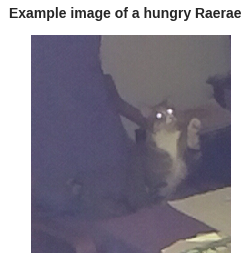

In [5]:
selectedImage = hungry[2]
print("File path: ", selectedImage)
plt.figure()
plt.imshow(preprocess_image(selectedImage, Y, X, HEIGHT, WIDTH))
plt.suptitle("Example image of a hungry Raerae", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

## Import Data and Preprocess
Image preprocessing is done to:
* crop the area of the photo where the cat stands (and since the camera is stationary, this shouldn't ever change)
* standardize pixel values to prevent neuron oversaturation

In [0]:
all_images = []
all_labels = []
for fn in hungry:
  preprocessed_image = preprocess_image(fn, Y, X, HEIGHT, WIDTH, True)
  all_images.append(preprocessed_image)
  all_labels.append(1)
for fn in not_hungry:
  preprocessed_image = preprocess_image(fn, Y, X, HEIGHT, WIDTH, True)
  all_images.append(preprocessed_image)
  all_labels.append(0)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

total_samples = len(all_images)

# split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.20, random_state=42)

### Calculate Class Weights
Positive training examples are underrepresented in the data, and using class weights will help speed up training

In [7]:
positive_training_examples = np.where(y_train == 1.)[0]
print("Positive example indices: ", positive_training_examples)
print(np.size(positive_training_examples) / len(y_train) * 100, " percentage of examples are positive")

classWeight = compute_class_weight('balanced', [0, 1], all_labels) 
classWeight = dict(enumerate(classWeight))
print(classWeight)

Positive example indices:  [  47  105  187  197  205  218  279  340  377  415  420  424  468  471
  498  499  508  519  522  525  529  536  541  559  582  587  590  601
  626  654  657  667  670  693  704  742  747  765  776  811  820  825
  855  881  934  941  959  971  973  995 1020 1034 1039 1072 1080 1145
 1237 1254 1255 1293 1307 1314 1337]
4.595185995623632  percentage of examples are positive
{0: 0.5248009797917943, 1: 10.580246913580247}


In [0]:
def cnn_model(height, width, channels):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                   activation='relu',
                   input_shape=(height, width, channels)))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.layers.Flatten())
  model.add(tf.layers.Dense(1000, activation='relu'))
  model.add(tf.layers.Dense(1, activation='sigmoid'))
  
  return model

# Hyperparameters
batch_size = 48
epochs = 6
learning_rate = 0.00001
decay = 0.001

cnn_model = cnn_model(HEIGHT, WIDTH, NUM_CHANNELS)
opt = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay)

cnn_model.compile(opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])


In [9]:
cnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_data=(X_test, y_test), class_weight=classWeight)

Train on 1371 samples, validate on 343 samples
Epoch 1/6
1371/1371 [==============================] - 23s 17ms/step - loss: 0.2624 - binary_accuracy: 0.8796 - val_loss: 0.1071 - val_binary_accuracy: 0.9563
Epoch 2/6
1371/1371 [==============================] - 15s 11ms/step - loss: 0.1162 - binary_accuracy: 0.9592 - val_loss: 0.2879 - val_binary_accuracy: 0.9213
Epoch 3/6
1371/1371 [==============================] - 15s 11ms/step - loss: 0.0474 - binary_accuracy: 0.9898 - val_loss: 0.1344 - val_binary_accuracy: 0.9708
Epoch 4/6
1371/1371 [==============================] - 14s 11ms/step - loss: 0.0629 - binary_accuracy: 0.9730 - val_loss: 0.0596 - val_binary_accuracy: 0.9883
Epoch 5/6
1371/1371 [==============================] - 14s 10ms/step - loss: 0.0256 - binary_accuracy: 0.9934 - val_loss: 0.0365 - val_binary_accuracy: 0.9942
Epoch 6/6
1371/1371 [==============================] - 14s 10ms/step - loss: 0.0246 - binary_accuracy: 0.9949 - val_loss: 0.0548 - val_binary_accuracy: 0.9942

File path:  drive/My Drive/raerae_hungry/hungry/2018-11-19-23-42-06.jpg


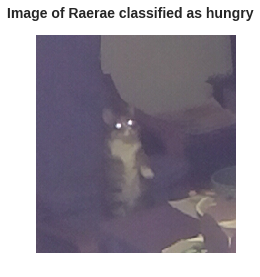

In [26]:
selectedImage = hungry[randint(0, len(hungry)-1)]
print("File path: ", selectedImage)

confidence = cnn_model.predict(np.reshape(preprocess_image(selectedImage, Y, X, HEIGHT, WIDTH), [1, HEIGHT, WIDTH, NUM_CHANNELS]))[0][0]
if (confidence > 0.5):
  prediction = "hungry"
else:
  prediction = "not hungry"
  
plt.figure()
plt.imshow(preprocess_image(selectedImage, Y, X, HEIGHT, WIDTH))
plt.suptitle("Image of Raerae classified as " + prediction, fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

In [12]:
# serialize model to YAML
model_yaml = cnn_model.to_yaml()
with open("cnn_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
cnn_model.save_weights("cnn_model.h5")
print("Saved model to disk")

Saved model to disk


## Quantize Model
Inference will be run in real time on my Raspberry Pi Model B, so the reduced model size and latency will be useful

In [0]:
# TODO

## Download

In [0]:
from google.colab import files
files.download('cnn_model.yaml')
files.download('model.h5')